We will use the daily spreadsheet from EU CDC containing new cases and deaths per country per day.

Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [9]:
!pip install pandas numpy matplotlib

In [1]:
import pandas as pd
import numpy  as np

%matplotlib inline

We read our dataframe from the previous ETL steps

Let's start with __NL__ as an exploration and leave generalization for later. We create a dataframe `dg` with the non zero (for the logarithm) cases from the original data and sort by date ascending, which is useful for the visualizations later on.

In [2]:
df = pd.read_csv('cases.csv')
df = df.drop(columns='Unnamed: 0')
df['dateRep'] = df['dateRep'].astype('datetime64')

In [3]:
dg = df[(df['geoId'] == 'NL') & (df['cases'] > 0)].sort_values(['dateRep'])
dg.describe()

,day,month,year,cases,deaths,popData2018
count,61.000000,61.000000,61.0,61.000000,61.000000,61.0
mean,15.721311,3.426230,2020.0,626.967213,74.065574,17231017.0
std,8.830121,0.561516,0.0,438.358224,65.656396,0.0
min,1.000000,2.000000,2020.0,1.000000,0.000000,17231017.0
25%,8.000000,3.000000,2020.0,155.000000,2.000000,17231017.0
50%,16.000000,3.000000,2020.0,729.000000,78.000000,17231017.0
75%,23.000000,4.000000,2020.0,1019.000000,132.000000,17231017.0
max,31.000000,4.000000,2020.0,1335.000000,234.000000,17231017.0


Most algorithms (such as our curve fitter) only take numerical data as inputs for a model, so we add a column representing the date as days since January 1st, 2019. We take a rolling week window to smooth the weekly reporting cycle for cases, because many of the cases over the weekend end up in the reported data for Tuesdays and Wednesdays. Now we can take the logarithm to create our parabola curve for fitting.

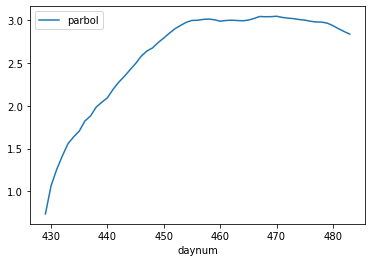

In [4]:
dg['daynum'] = (dg['dateRep'] - pd.Timestamp('2019-01-01')).dt.days.astype('int')
dg['parbol'] = np.log10(dg['cases'].rolling(7).mean())

dg.plot(x='daynum', y='parbol')

Now we can use polynomial regression to estimate the curve with `polyfit`. We are looking for a parabola, so we use a second order approximation. The outputs are factors a, b, and c for the function `ax^2 + bx + c`. The curve fitter doesn't accept missing values (created because of the rolling window), so we drop those first creating a dataframe `dt` for the actual fit.

In [5]:
dt = dg.dropna()
fit = np.polyfit(dt['daynum'], dt['parbol'], 2)
print(fit)

[-1.45644534e-03  1.35901524e+00 -3.13899399e+02]


Once we have those, we take the exponential and we get the estimated curve for that time series. The `polyval` function takes the results of `polyfit` and applies them to the input data.

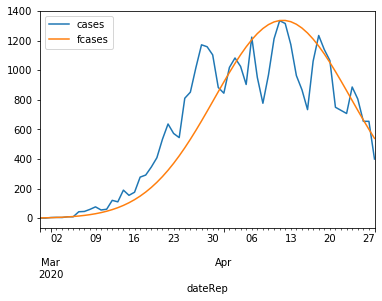

In [6]:
dg['fcases'] = 10 ** np.polyval(fit, dg['daynum'])
dg.plot(x='dateRep', y=['cases', 'fcases'])

That shows a decent fit. Lets prepare a prediction by creating a dataframe `dp` with 30 future dates and score them.

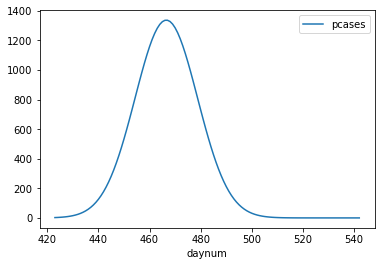

In [7]:
dp = pd.DataFrame({'daynum': range(dg['daynum'].min(), dg['daynum'].max() + 60)})
dp['pcases'] = 10 ** np.polyval(fit, dp['daynum'])
dp.plot(x='daynum', y='pcases')

Finally we concatenate the predicted data to the original dataframe so we can use it in our visualizations.

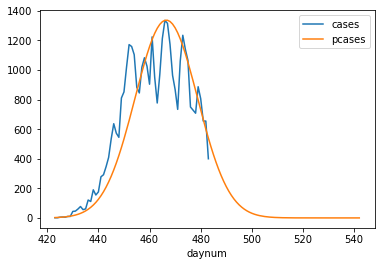

In [8]:
dg = pd.concat([dg, dp], axis=0, ignore_index=False, sort=True)
dg.plot(x='daynum', y=['cases', 'pcases'])